# image denoising in wavelet domain

By Diyun Lu and Yihan Zhong

Simulate a noisy version of the music using the noises at various SNR Level

In [ ]:
import math   
import numpy as np 
import librosa
import matplotlib.pyplot as plt
from scipy import signal

This function give a signal, noise (audio) and desired SNR, this gives the noise (scaled version of noise input) that gives the desired SNR

In [ ]:
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.linalg.norm(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #current RMS of noise
    RMS_n_current=math.sqrt(np.linalg.norm(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    return noise

read the music file

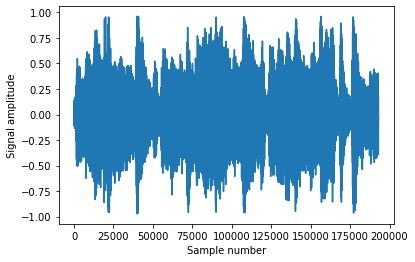

192939

In [ ]:
music_file='/content/music.wav'
music, sr = librosa.load(music_file)
#music=np.interp(music, (music.min(), music.max()), (-1, 1))
plt.plot(music)
plt.xlabel("Sample number")
plt.ylabel("Signal amplitude")
plt.show()
len(music)

read the noise and controlling it with different snr

In [ ]:
def get_noise(SNR):
  noise_file_list=['noise1.wav','noise2.wav','noise3.wav']
  noise_list=[]
  for noise_file in noise_file_list:    
    noise, sr = librosa.load(noise_file)
    noise=get_noise_from_sound(music,noise,SNR)
    noise_list.append(noise)
  return noise_list

SNR = 5.0000005724875365


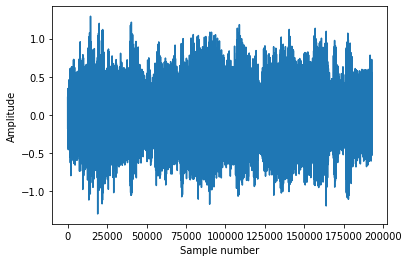

SNR = 4.999999385328068


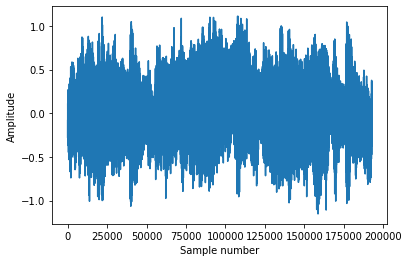

SNR = 5.000000275697639


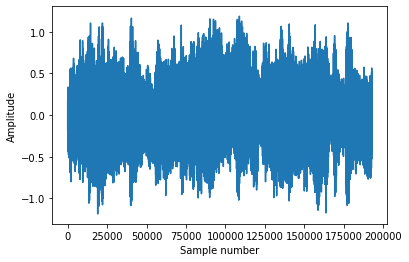

In [ ]:
snr=5

signal_noise_list_5=[]
noise_list=get_noise(snr)
for noise in noise_list:
  print("SNR = " + str(20*np.log10(math.sqrt(np.linalg.norm(music**2))/math.sqrt(np.linalg.norm(noise**2)))))
  signal_noise=music+noise
  signal_noise_list_5.append(signal_noise)
  plt.plot(signal_noise)
  plt.xlabel("Sample number")
  plt.ylabel("Amplitude")
  plt.show()

SNR = 10.000001220091734


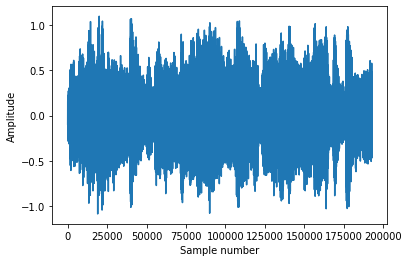

SNR = 9.999998404495944


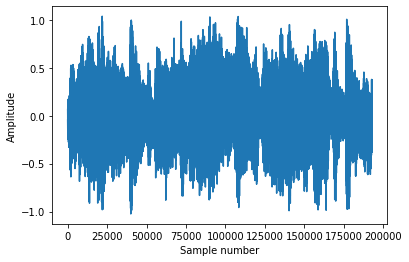

SNR = 10.0000002815596


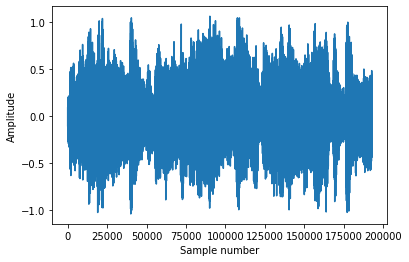

In [ ]:
snr=10

signal_noise_list_10=[]
noise_list=get_noise(snr)
for noise in noise_list:
  print("SNR = " + str(20*np.log10(math.sqrt(np.linalg.norm(music**2))/math.sqrt(np.linalg.norm(noise**2)))))
  signal_noise=music+noise
  signal_noise_list_10.append(signal_noise)

  plt.plot(signal_noise)
  plt.xlabel("Sample number")
  plt.ylabel("Amplitude")
  plt.show()


## Implement the spectral substraction method

### Using stft to do the time-frequency transformation

In [ ]:
sn_list=[]
for noise in noise_list:
  f, t, Zxx2 = signal.stft(noise,fs=22050, nperseg=1024)
  sn=np.mean(np.power(Zxx2, 2), axis=1)
  sn_list.append(sn)

In [ ]:
Yn_list=[]
for signal_noise in signal_noise_list_10:
  f, t, Zxx1 = signal.stft(signal_noise,fs=22050, nperseg=1024)
  Yn=np.power(Zxx1,2)
  Yn_list.append(Yn)

In [ ]:
def spectrum_substraction(sn,yn,lamb):
  sn2=np.array([sn,]*378).transpose()
  cond_matrix=1-np.power(lamb,2)*np.divide(sn2,Yn)
  cond_matrix[cond_matrix < 0] = 0
  spectral_substruct=Zxx1*cond_matrix
  return spectral_substruct

In [ ]:
# general formula with all parameters (default parameters makes is equivalent simple formula)
def general_spectral_subtraction(Y, S, lamda, alpha=2, beta=1, gamma=0):
    X = np.zeros_like(Y)
    S = np.tile(np.expand_dims(S,axis=1), Y.shape[1])
    bool_mask = (np.abs(Y)**alpha) > ((lamda**alpha)*(np.abs(S)**alpha))
    first_case = Y * (1 - (((lamda**alpha)*(np.abs(S)**alpha))/(np.abs(Y)**alpha)))**beta
    second_case = gamma*(Y/np.abs(Y))*np.abs(S)
    X = (first_case * np.int64(bool_mask)) + (second_case * np.int64(~bool_mask))
    return X

# simple formula with only lamda as parameter
def spectral_subtraction(Y, S, lamda):
    X = np.zeros_like(Y)
    S = np.tile(np.expand_dims(S,axis=1), Y.shape[1])
    right_term = 1 - ( ((lamda*np.abs(S))**2) / (np.abs(Y)**2) )
    right_term = right_term.clip(min=0)   #  max(right_term, 0)
    X = Y * right_term
    return X

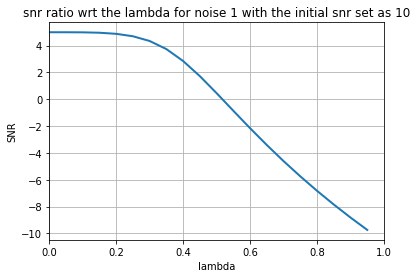

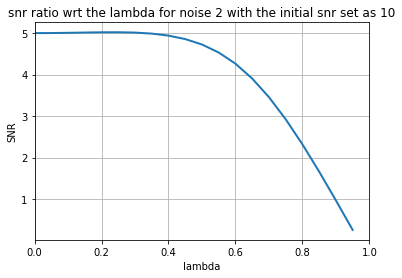

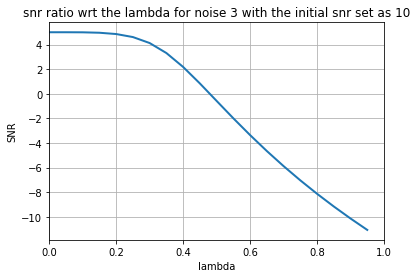

In [ ]:
lambda_list=np.arange(0, 1, 0.05).tolist()
snr_list=[[]]

for i, (sn,yn) in enumerate(zip(sn_list,Yn_list)):
  snr_l=[]
  
  for lamb in lambda_list:
    _, xrec = signal.istft(spectrum_substraction(sn.reshape([len(sn),1]),yn,lamb),fs=22050,nperseg=1024)
    xrec=np.resize(xrec, len(music))
    snr=20*np.log10(math.sqrt(np.linalg.norm(music**2))/math.sqrt(np.linalg.norm((music-xrec)**2)))
    snr_l.append(snr)
    
  fig, ax = plt.subplots()
  ax.plot(lambda_list, snr_l, linewidth=2.0)
  ax.set_xlabel('lambda')
  ax.set_ylabel('SNR')
  ax.set(xlim=(0, 1))
  ax.set_title(f'snr ratio wrt the lambda for noise {i+1} with the initial snr set as 10')
  plt.grid()
  plt.show()



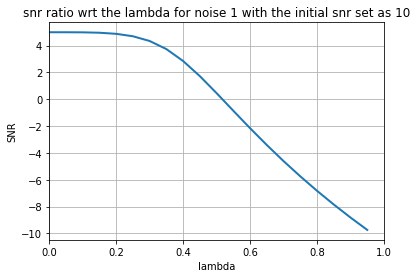

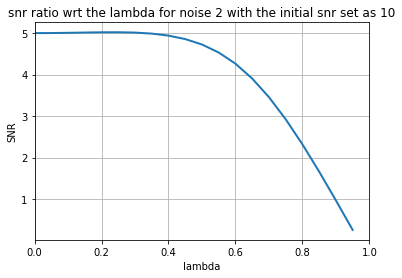

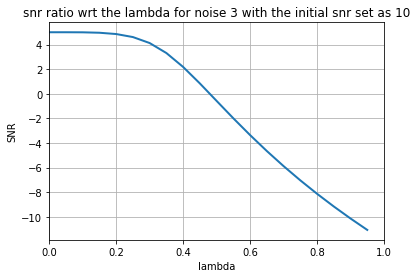

In [ ]:
lambda_list=np.arange(0, 1, 0.05).tolist()
snr_list=[[]]

for i, (sn,yn) in enumerate(zip(sn_list,Yn_list)):
  snr_l=[]
  
  for lamb in lambda_list:
    _, xrec = signal.istft(spectrum_substraction(sn,yn,lamb),fs=22050,nperseg=1024)
    xrec=np.resize(xrec, len(music))
    snr=20*np.log10(math.sqrt(np.linalg.norm(music**2))/math.sqrt(np.linalg.norm((music-xrec)**2)))
    snr_l.append(snr)
    
  fig, ax = plt.subplots()
  ax.plot(lambda_list, snr_l, linewidth=2.0)
  ax.set_xlabel('lambda')
  ax.set_ylabel('SNR')
  ax.set(xlim=(0, 1))
  ax.set_title(f'snr ratio wrt the lambda for noise {i+1} with the initial snr set as 10')
  plt.grid()
  plt.show()

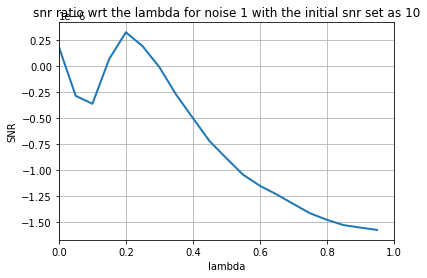

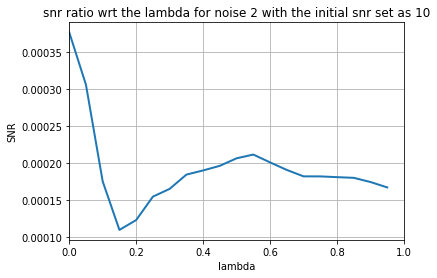

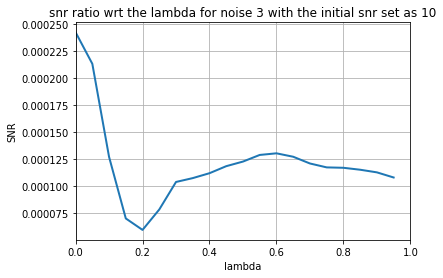

In [ ]:
lambda_list=np.arange(0, 1, 0.05).tolist()
snr_list=[[]]

for i, (sn,yn) in enumerate(zip(sn_list,Yn_list)):
  snr_l=[]
  
  for lamb in lambda_list:
    _, xrec = signal.istft(general_spectral_subtraction(sn.reshape([len(sn),1]),yn,lamb),fs=22050,nperseg=1024)
    xrec=np.resize(xrec, len(music))
    snr=20*np.log10(math.sqrt(np.linalg.norm(music**2))/math.sqrt(np.linalg.norm((music-xrec)**2)))
    snr_l.append(snr)
    
  fig, ax = plt.subplots()
  ax.plot(lambda_list, snr_l, linewidth=2.0)
  ax.set_xlabel('lambda')
  ax.set_ylabel('SNR')
  ax.set(xlim=(0, 1))
  ax.set_title(f'snr ratio wrt the lambda for noise {i+1} with the initial snr set as 10')
  plt.grid()
  plt.show()